# Introduction to DiffPrivLib

[DiffPrivLib](https://diffprivlib.readthedocs.io/en/latest/index.html) is a python library dedicated to differential privacy and machine learning. It is based on `scikit-learn` library. 

Some other [introduction notebooks](https://github.com/IBM/differential-privacy-library/tree/main/notebooks) are available directly in the official library repository.

## Step 1: Install the Library

DiffPrivLib is available on pypi, it can be installed via the pip command. We will use the latest version of the library: version 0.6.6.

In [1]:
!pip install diffprivlib==0.6.6

## Step 2: Load and Prepare Data

### Load penguin dataset
In this notebook, we will work with the [penguin dataset]("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") from [seaborn datasets](https://github.com/mwaskom/seaborn-data).
We load the dataset via pandas in a dataframe `df`.

In [1]:
import pandas as pd

In [2]:
path_to_data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(path_to_data)

We can look at the first rows of the dataframe to get to know the data:

In [3]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
df["species"].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

### Handle null values
DiffPrivLib does not allow null values so we will have to remove or convert them. For simplicity, we will just drop the rows with null values from the dataset.

In [5]:
print(f"{df.shape[0]} rows before dropping nulls.")
df = df.dropna()
print(f"{df.shape[0]} rows after dropping nulls.")

344 rows before dropping nulls.
333 rows after dropping nulls.


### Encode columns for Machine Learning

In the following analysis, we will use the `sex` column as a feature column. We encode the `MALE` and `FEMALE` strings in numbers that the models will be able to use.

In [6]:
df["sex"] = df["sex"].map({"MALE": 0, "FEMALE": 1})

In [7]:
df.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1


## Step 3: Logistic Regression with DiffPrivLib

We want to predict penguin's species, i.e., Adelie, Chinstrap, or Gentoo, based on bill length, bill depth, flipper length, body mass and sex. 
Therefore, we will estimate a multiclass logistic regression:

$$
Pr(Y_i = \{species_k\}) = \frac{e^{\beta_k X_i}}{1 + \sum_{j = 1}^3 e^{\beta_j X_i}}.
$$

We first split the data between features and target (to predict).

In [8]:
# List of features columns
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'sex']

# Target column
target_columns = ['species']

In [9]:
# Create feature and target dataframe
feature_data = df[feature_columns]
label_data = df[target_columns]

And then split the data to get a training set, i.e. data used to estimate the model's parameter, and a testing set, .i.e. data used to estimate the performance of the model, with the [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#train-test-split) from scikit-learn.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Define size of the test set
TEST_SIZE = 0.2 # use 20% of data for testing
RANDOM_STATE = 1 # Seed for random selection of test set

x_train, x_test, y_train, y_test = train_test_split(
    feature_data,
    label_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)
y_train = y_train.to_numpy().ravel()

We first start by fitting a logistic regression using the non-DP alogrithm from the scikit-learn library for reference.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Create model
model = LogisticRegression(max_iter = 1000)

# Fit the model
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# Model's prediction performance (percentage of correctly classified labels):
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9850746268656716


We now attempt to fit a differentially private logistic regression using the DiffPrivLib library; [see doc](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#logistic-regression):

In [13]:
from diffprivlib import models

In [14]:
# Create logistic regression model
log_reg_model = models.LogisticRegression(epsilon = 1000.0, max_iter=1000)

We now fit the model on the training set and compute its accuracy; [doc here](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.LogisticRegression.score):

In [15]:
# Fit the model
log_reg_model.fit(x_train, y_train)

# Model's prediction performance (percentage of correctly classified labels):
print("Accuracy:", log_reg_model.score(x_test, y_test))

Accuracy: 0.9701492537313433


/home/bfs/.local/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:231: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


The model runs, is estimated and provide a performance comparable to the non-DP model, however the function return a worrisome privacy leak warning.

## Step 3': Logistic regression with explicit L2-norm bound

We get a `PrivacyLeakWarning` warning because we did not specify the `data_norm` parameter. 

Differential privacy mechanisms need to know how much one individual’s record can change the model. In the case of the `LogisticRegression`, this depends on the maximum $L2$ norm of any row, which in turn depends on the size of feature vectors. `data_norm` is that bound: The maximum L2 norm of any single row (feature vector) in the dataset. 

If it is not specified, DiffPrivLib will infer if from the training data. As this compution is a query in itself, this may leak information about the dataset (e.g. what the max value was), hence the PrivacyLeakWarning. To avoid that, we can specify the bounds with `data_norm` using domain knowledge independent of the values in the dataset.

We assume that the data originates from an official survey for which possible values of the field are considered public information, in particular:
- bill length $\in [30.0, 65.0]$,
- bill depth $\in [13.0, 23.0]$,
- flipper length $\in [150.0, 250.0]$,
- body mass $\in [2000.0, 7000.0]$,
- sex $\in [0, 1]$.

Formally, for a row $x = (x_1, \ldots, x_d)$, its L2 norm is $\|x\|_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2}$.

As the columns takes only positive values, the $L2$ norm of a row $x$ can be bounded using the feature maximum values:

$$
\|x\|_2 = \sqrt{ (\text{max bill length})^2 + (\text{max bill depth})^2 + (\text{max flipper length})^2 + (\text{max body mass})^2 + (\text{max sex})^2 }
$$

Writing all this information in a metadata dictionnary, we can then specify the `data_norm`:

In [16]:
import numpy as np

In [17]:
# List all metadata bounds
metadata_bounds = {
    'bill_length_mm': {'lower': 30.0, 'upper': 65.0},
    'bill_depth_mm': {'lower': 13.0, 'upper': 23.0},
    'sex': {'lower': 0.0, 'upper': 1.0}, 
}

In [18]:
# TODO: compute the data_norm
# data_norm = ...

# Correction
data_norm = np.sqrt(sum(v['upper']**2 for v in metadata_bounds.values()))
print("data_norm =", data_norm)

data_norm = 68.95650803223725


We now re-define the logistic regression model using the pre-defined `data_norm` parameter:

In [19]:
log_reg_model_with_bounds = models.LogisticRegression(epsilon = 1e3, data_norm=data_norm, max_iter=1000)

We now fit the model on the training set and compute its accuracy; [doc here](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.LogisticRegression.score):

In [20]:
# Fit model
log_reg_model_with_bounds.fit(x_train, y_train)

# Model's prediction performance (percentage of correctly classified labels):
print("Accuracy:", log_reg_model_with_bounds.score(x_test, y_test))

Accuracy: 0.9701492537313433


You now obtained a model with a comparable prediction performance without the privacy leak warning. 

## Step 3'': Logistic regression with standard scaler pre-processing

In the previous model, we trained logistic regression on raw features. Sometime re-scaling helps improving the model's performance.  
Since the features have very different values' ranges (for example, body mass in the thousands versus sex as a binary 0/1), this can cause several issues:

- the optimizer may converge more slowly  
- model coefficients can become unbalanced  
- in the case of differential privacy, very large row norms can occur, which increases the amount of noise added  

To address this, we will create a DP-pipeline that first scales the data using a 
[`StandardScaler`](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#standard-scaler), and then fits a logistic regression.  

Scaling the features ensures they are on a comparable range, which improves optimization and reduces row norms.  
This leads to better performance and more accurate differentially private estimates.  

#### Step A - `StandardScaler`

The `StandardScaler` model standardizes each feature by removing the mean and scaling to unit variance, but unlike scikit-learn’s version, the standardization is done under DP guarantees.

The transformation applied on the raw data is: 
$$
z = \frac{x - u}{s}.
$$
where:
- $u$ is the differentially private mean
- $s$ is the differentially private standard deviation

So the scaler will compute the mean and standard deviation for each re-scaled column using queries protected with a Laplace mechanism which requires proper calibration based on the column's metadata, but unlike the logistic regression model, the `StandardScaler` does not take a `data_norm` parameter. Instead, it requires `bounds` for each feature in order to determine the sensitivity and calibrate the amount of noise to add.  

For a given column, the sensitivity is defined as $sens = \text{max} - \text{min}$.

For example, consider the feature `bill_length_mm` with bounds in $[30.0, 65.0]$, the sensitivity is $sens = 65.0 - 30.0 = 35.0$.

If we use the Laplace mechanism, the privatized query for this scaling this feature would be  

$$
u = data\_average + \text{Lap}\left(0, \frac{35.0}{\epsilon}\right), \qquad s = data\_std + \text{Lap}\left(0, \frac{35.0}{\epsilon}\right)
$$

where $\epsilon$ is the privacy budget.

This ensures the mean and standard deviation are privatized, while the transformed data itself is not differentially private.

First, we compute the input feature data bounds of the standard scaler. Use the `get_bounds` function to instantiate them.

In [21]:
# Function returning the columns bounds from the metadata
def get_bounds(metadata_bounds, columns):
    lower = [metadata_bounds[col]["lower"] for col in columns]
    upper = [metadata_bounds[col]["upper"] for col in columns]
    return (lower, upper)

In [22]:
# TODO: compute the feature_bounds of the input data
# The expected format is a tuple (list_of_lower_bounds, list_of_upper_bounds)
# feature_bounds = get_bounds(..., ...)

# Correction
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
feature_bounds

([30.0, 13.0, 0.0], [65.0, 23.0, 1.0])

We then instantiate and train the `StandardScaler` on the training data:

In [23]:
scaler = models.StandardScaler(epsilon = 0.5, bounds= feature_bounds)
scaler = scaler.fit(x_train)

And transform the training and testing data with the trained scaler:

In [24]:
scaled_train_data = scaler.transform(x_train)
scaled_test_data = scaler.transform(x_test)

#### Step B - `LogisticRegression`
After scaling, we apply the same differentially private logistic regression classifier.

As before, this step requires a `data_norm`. 

However,
- The StandardScaler transformed each feature as $z = \frac{x - u}{s}$.
- This changes the feature ranges, so the row norms (and their maximum possible value) also change.
- To guarantee privacy correctly, we must compute the worst-case row norm after this transformation, based on:
    - the original feature bounds,
    - and the privatized mean and variance learned by the scaler.

The new scaled bounds for each feature are obtained by applying the transformation to the original bounds. The maximum possible $L2$ norm across these bounds becomes the new `data_norm` to use in logistic regression.

We retrieve the trained model parameters (mean $u$ and variance $s^2$). They are available in the trained `StandardScaler` object with one value per feature:

In [25]:
means = scaler.mean_
for col, u in zip(feature_columns, means):
    print(f"Mean of {col} is {u}.")

Mean of bill_length_mm is 41.909773274307454.
Mean of bill_depth_mm is 15.548055543395341.
Mean of sex is 0.5142791976095382.


In [26]:
# TODO: Look at the StandardScaler documentation
# variances = ...

# Correction
variances = scaler.var_

In [27]:
for col, s in zip(feature_columns, variances):
    print(f"Variance of {col} is {s}.")

Variance of bill_length_mm is 139.39003937570874.
Variance of bill_depth_mm is 12.866631312371398.
Variance of sex is 0.2461806172646558.


And compute the new scaled bounds:

In [28]:
def get_scaled_bounds(feature_bounds, means, variances):
    """
    Compute new feature bounds after applying a StandardScaler transform:
        z = (x - u) / s

    Args:
        feature_bounds: tuple (lower_bounds, upper_bounds), each a list of floats
        means: list of feature means (u)
        variances: list of feature variances
    Returns:
        scaled_bounds: tuple (scaled_lower_bounds, scaled_upper_bounds), each a list of floats
    """
    lower, upper = feature_bounds
    stds = np.sqrt(variances)

    scaled_lower = []
    scaled_upper = []

    for l, u, mean, std in zip(lower, upper, means, stds):
        z_lower = (l - mean) / std
        z_upper = (u - mean) / std
        scaled_lower.append(min(z_lower, z_upper))
        scaled_upper.append(max(z_lower, z_upper))

    return (scaled_lower, scaled_upper)

In [29]:
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
scaled_bounds = get_scaled_bounds(feature_bounds, means, variances)

Compute the new norm:

In [30]:
# TODO: compute the scaled_data_norm
# scaled_data_norm = ...

# Correction
after_scaler_data_norm = np.sqrt(sum(v**2 for v in scaled_bounds[1]))
print("after_scaler_data_norm =", after_scaler_data_norm)

after_scaler_data_norm = 3.0164896473474303


Now, we initialise the new classification model and train it on the scaled train data:

In [31]:
# Create LR model
rescaled_log_reg_model =  models.LogisticRegression(epsilon = 100.0, data_norm = after_scaler_data_norm)

# Fit the LR model
rescaled_log_reg_model.fit(scaled_train_data, y_train)

# Model's prediction performance (percentage of correctly classified labels):
print("Accuracy:", rescaled_log_reg_model.score(scaled_test_data, y_test))

Accuracy: 0.9701492537313433


We obserbe that we get a similar performance than the model without rescaling, however we used a much lower privacy-loss budget to obtain a similar performance.

We can look at the intercepts and estimated coefficients for the linear regression problem:

In [32]:
intercepts = rescaled_log_reg_model.intercept_
print(f"There are {len(intercepts)}, one for each species.")
print(f"Intercepts: {intercepts}")

There are 3, one for each species.
Intercepts: [-0.6216691  -4.26365003  0.83942008]


In [33]:
coefficients = rescaled_log_reg_model.coef_
print(f"The table of coefficient has of shape {coefficients.shape}, which corresponds to our 3 target species and {len(feature_columns)} features.")
print(f"Coefficients: {coefficients}")

The table of coefficient has of shape (3, 3), which corresponds to our 3 target species and 3 features.
Coefficients: [[-5.63305437  2.29108954 -0.41385536]
 [ 4.19643136  3.18714346  1.43601373]
 [ 1.89251719 -5.91178292 -0.90450577]]


#### Step C - `Pipeline`
Instead of training the standard scaler and logistic regression separatelly, it is possible to write a unique `pipeline` which combines the two models in an object.
Write a pipeline with the two models below. 

Note: For this example, we can assume that the `after_scaler_data_norm` computed in step 2 is still valid.

In [34]:
from sklearn.pipeline import Pipeline

In [35]:
# TODO: Complete pipeline and train it on the training data. 
# pipeline_with_scaler = Pipeline([
#    ('scaler', ...),
#    ('classifier', ...)
# ])
# pipeline_with_scaler = dpl_pipeline_with_scaler.fit(..., ...)

# Correction
pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds = feature_bounds)),
    ('classifier', models.LogisticRegression(epsilon = 1e2, data_norm = after_scaler_data_norm))
])
pipeline_with_scaler = pipeline_with_scaler.fit(x_train, y_train)

And evaluate the score of this new model on the test data:

In [36]:
# TODO: Evaluate the score of this new pipeline
# sc_score = ...

# Correction
sc_score = pipeline_with_scaler.score(x_test, y_test)
sc_score

0.9701492537313433

### Privacy loss budget accountant

Another important parameter in DiffPrivLib is the `accountant`. It enables to track the spent budget accross multiple steps in a pipeline and/or accross multiple pipelines.

To do so, the same `accountant` instance of `BudgetAccountant` must be provided as input argument of the pipeline and/or models. 

We rewrite here the previous pipeline with an `accountant`.

In [37]:
from diffprivlib import BudgetAccountant

In [38]:
accountant = BudgetAccountant()

pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=feature_bounds, accountant=accountant)),
    ('classifier', models.LogisticRegression(epsilon = 1e2, data_norm=after_scaler_data_norm, accountant=accountant))
])

With the `.total()` method, we can see the budget spent by the models. For now it was not fitted on the data so the budget is 0.

In [39]:
accountant.total()

(epsilon=0, delta=0.0)

We train the model on the data and check the budget again:

In [40]:
pipeline_with_scaler = pipeline_with_scaler.fit(x_train, y_train)
accountant.total()

(epsilon=100.5, delta=0.0)

As expected the budget from both steps is spent 0.5 + 1e2 = 100.5 epsilon.

### Use the model for prediction

We can use the model to predict a species depending on the feature values. 

For illustration, we make prediction for three hypothetical on female penguins with:
- the smallest possible value for all features (lower bound)
- the biggest possible value for all features (upper bound)
- the medium value for all features

In [41]:
# Create feature data
x_to_predict_dict = {}
for col in feature_columns:
    lower = metadata_bounds[col]['lower']
    upper = metadata_bounds[col]['upper']
    midpoint = (lower + upper) / 2
    x_to_predict_dict[col] = [lower, upper, midpoint]

x_to_predict = pd.DataFrame(x_to_predict_dict)
x_to_predict

,bill_length_mm,bill_depth_mm,sex
0,30.0,13.0,0.0
1,65.0,23.0,1.0
2,47.5,18.0,0.5


In [42]:
# Compute prediction with estimated model
predictions = pipeline_with_scaler.predict(x_to_predict)
x_to_predict["predictions"] = predictions
x_to_predict

,bill_length_mm,bill_depth_mm,sex,predictions
0,30.0,13.0,0.0,Adelie
1,65.0,23.0,1.0,Chinstrap
2,47.5,18.0,0.5,Chinstrap


Can you compute the prediction for the data in the test set ?

In [43]:
# TODO: Predict the species of the data in the test set
# predictions = ...

# Correction
predictions = pipeline_with_scaler.predict(x_test)

## Step 4: Clustering KMeans

DiffPrivLib also allows to use K-Means clustering [(see doc)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#k-means), i.e., that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean; see [link](https://en.wikipedia.org/wiki/K-means_clustering) for methodological details.

We attempt to find `N_CLUSTERS` clusters using the features 'bill_length_mm', 'bill_depth_mm', and 'body_mass_g'. As it is unsupervised learning, there is no target column. For this reason, there is no need for a training and testing set. 

In [44]:
# Number of clusters
N_CLUSTERS = 3
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'body_mass_g']
feature_data = df[feature_columns]

### StandardScaler and KMeans Pipeline
Similarly to the logistic regression, we will first use a `StandardScaler` followed by `KMeans`, to improve the algorithm performance.

As before, we need to determine all required parameter to avoid a `PrivacyLeakWarning`. For the `StandardScaler`, we get the input bounds from the metadata:

In [45]:
# List all metadata bounds
metadata_bounds = {
    'bill_length_mm': {'lower': 30.0, 'upper': 65.0},
    'bill_depth_mm': {'lower': 13.0, 'upper': 23.0},
    'flipper_length_mm': {'lower': 150.0, 'upper': 250.0},
    'body_mass_g': {'lower': 2000.0, 'upper': 7000.0},
    'sex': {'lower': 0.0, 'upper': 1.0}, 
}

# Exctract bounds
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
feature_bounds

([30.0, 13.0, 2000.0], [65.0, 23.0, 7000.0])

We instantiate and fit the `StandardScaler` and apply the standard scaling on the feature data:

In [46]:
# Create scaler
scaler = models.StandardScaler(epsilon = 10.0, bounds=feature_bounds)

# Fit scaler
scaler = scaler.fit(feature_data)

# Rescale data
scaled_feature_data = scaler.transform(feature_data)

We also need to instantiate the `KMeans` pipeline. It will require a `bounds` parameter with the new scaled bounds (in output of the scaler) to be fed to the `K_Means` algorithm.

Can you compute them ?
Hint: You can use a similar logic as before and re-use the `get_scaled_bounds` function with the previously computed `means` and `variances`. Be careful, the bounds must be provided as a tuple of the form (list_lower_bounds, list_upper_bounds), like `feature_bounds` above.

In [47]:
# TODO: Instantiate the bounds after the `StandardScaler`
# after_scaler_bounds = ...

# Correction
after_scaler_bounds = get_scaled_bounds(feature_bounds, scaler.mean_, scaler.var_)

We have now everything to instantiate the k-means pipeline:

In [48]:
accountant = BudgetAccountant()
kmeans_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 10.0, bounds=feature_bounds, accountant=accountant)),
    ('kmeans', models.KMeans(n_clusters = N_CLUSTERS, epsilon = 50.0, bounds= after_scaler_bounds, accountant=accountant)),
])

Let's fit the K-Meand model on the clusters

In [49]:
# TODO: Fit the K-Mean pipeline
# kmeans_pipeline = ...

# Correction
kmeans_pipeline = kmeans_pipeline.fit(feature_data)
kmeans_pipeline

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epsilon,10.0
,bounds,"(array([ 30., 13., 2000.]), ...)"
,copy,True
,with_mean,True
,with_std,True
,random_state,None
,accountant,"BudgetAccount...), (50.0, 0)])"


We can look at the spent budget:

In [50]:
accountant.total()

(epsilon=60.0, delta=0.0)

And at the score of the model, which is the opposite of the value of X on the K-means objective.

In [51]:
kmeans_pipeline.score(feature_data)

-409.6053433507386

FYI: According to the official [documentation](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.KMeans.score), the `score` of the `K-means` model is the 'opposite of the value of X on the K-means objective'.

Ususally, the K-means objective is the *inertia*, i.e. the within-cluster sum of squared distances:

$$
\text{Inertia} = \sum_{i=1}^n \min_{c \in \text{clusters}} \lVert x_i - \mu_c \rVert^2
$$

where:  
- $x_i$ = a data point  
- $\mu_c$ = the centroid of cluster $c$  

The K-means algorithm tries to minimize inertia (tight, well-separated clusters), where a smaller value of `Inertia` is better.

DiffPrivLib is based on scikit-learn and in scikit-learn, by convention, higher scores are always better. Hence, to stay consistent, scikit-learn defines: $\text{score}(X) = - \text{Inertia}(X)$, which represent the same information, just with opposite signs.

We can use the model to predict the clusters:

In [52]:
# TODO: Predict clusters on feature_data with K-Mean pipeline
# predictions = ...

# Correction
predictions = kmeans_pipeline.predict(feature_data)

In [53]:
df["predictions"] = predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,0


We can plot the results to study the clusters

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
def plot_clusters(df, x, y, cluster_col="predictions", style_col="species"):
    """
    Plot two features colored by cluster predictions and shaped by species.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the features, cluster predictions, and species.
    x : str
        Feature name for the x-axis.
    y : str
        Feature name for the y-axis.
    cluster_col : str, default="predictions"
        Column name with cluster assignments.
    style_col : str, default="species"
        Column name for marker style (e.g., species).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=cluster_col,
        style=style_col,
        palette="deep",
        s=80
    )
    plt.title(f"DP KMeans Clustering: {x} vs {y}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

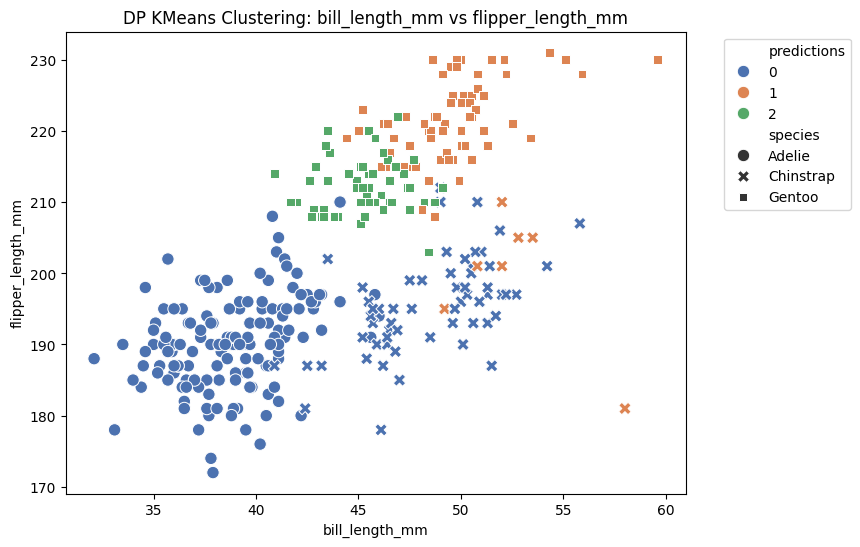

In [56]:
plot_clusters(df, x="bill_length_mm", y="flipper_length_mm")

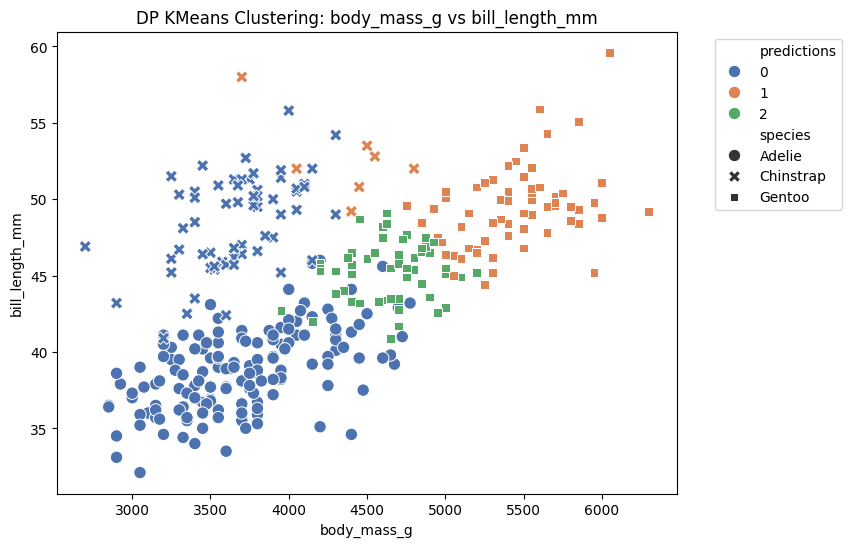

In [57]:
plot_clusters(df, x="body_mass_g", y="bill_length_mm")

Feel free to try various number of cluster options, feature selection and axis to plot!

We can check how the DP K-means result compare to the non-DP alogrithm.

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_data)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_scaled)

# 3. Predict cluster assignments
y_kmeans = kmeans.predict(X_scaled)

df["predictions_nonDP"] = y_kmeans
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,predictions_nonDP
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,0,2
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,0,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,0,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,0,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,0,2


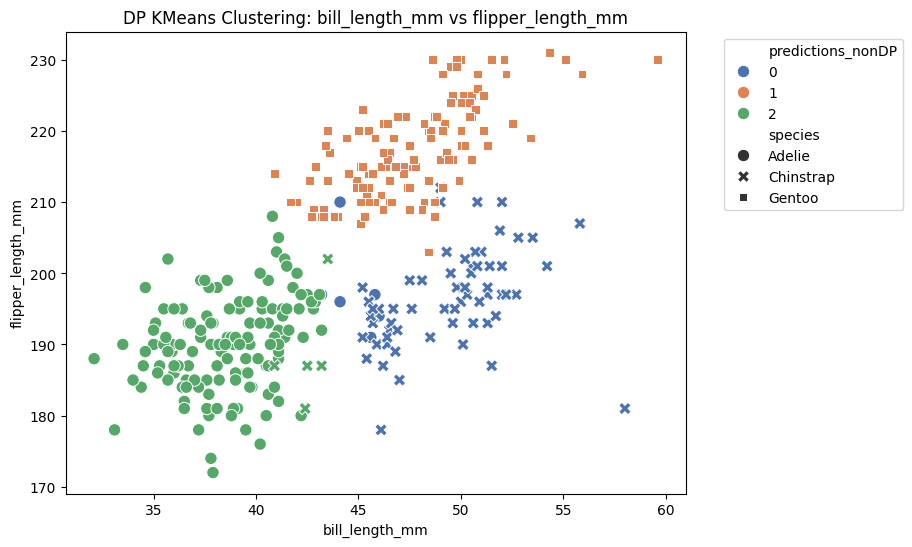

In [59]:
plot_clusters(df, x="bill_length_mm", y="flipper_length_mm", cluster_col="predictions_nonDP")

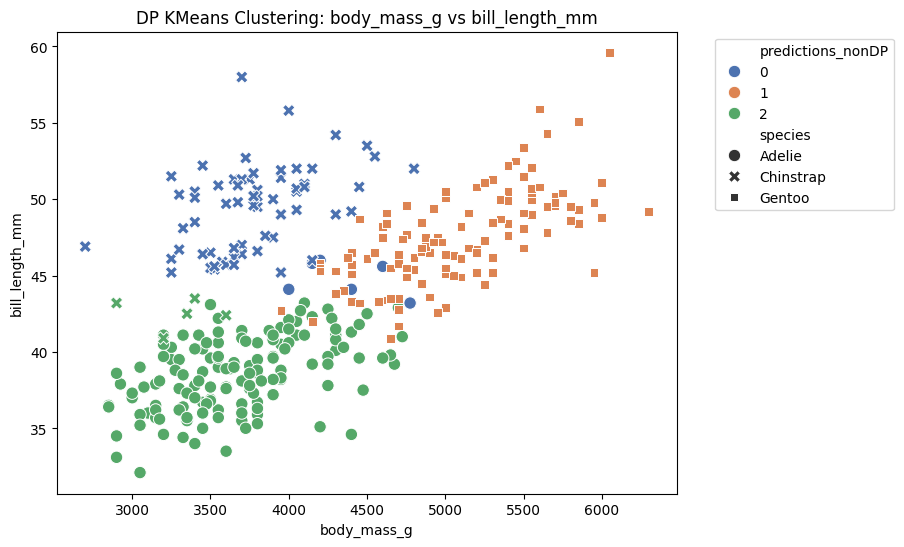

In [60]:
plot_clusters(df, x="body_mass_g", y="bill_length_mm", cluster_col="predictions_nonDP")

We see that we get similar results with the DP and non-DP clustering! You can try to reduce the privacy loss budget to see the algorithm's performance decrease.

## KMeans after PCA and StandardScaler

In cases where the number of columns in the data is large, alogrithms like k-means performs better if some dimension reduction is done beforehand.

We now try to do a dimensionality reduction to two components with a PCA before K-Means to see if we can obtain similar results when using all initial features. If you are unfamiliar with `PCA`, [this page](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) provides a good explanation.

The PCA model requires `bounds` and `data_norm` parameters. Using the same logic as before, re-instantiate the appropriate parameters in a first pipeline with a `StandardScaler` followed by a `PCA` model.

In [61]:
# Number of target dimensions
N_COMPONENTS = 2

# Selecte all featurs as input
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
feature_data_pca = df[feature_columns]

In [62]:
# List all metadata bounds
metadata_bounds = {
    'bill_length_mm': {'lower': 30.0, 'upper': 65.0},
    'bill_depth_mm': {'lower': 13.0, 'upper': 23.0},
    'flipper_length_mm': {'lower': 150.0, 'upper': 250.0},
    'body_mass_g': {'lower': 2000.0, 'upper': 7000.0},
    'sex': {'lower': 0.0, 'upper': 1.0}, 
}

# Exctract bounds
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
feature_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 250.0, 7000.0, 1.0])

In [63]:
# Create scaler
scaler = models.StandardScaler(epsilon = 10.0, bounds=feature_bounds)

# Rescale data
scaled_feature_data_pca = scaler.fit_transform(feature_data_pca)

In [64]:
# TODO: Using what we learned above, re-instantiate the appropriate bounds for the pipeline below
# after_scaler_bounds_pca = ...
# after_scaler_data_norm_pca = ...

# Correction
after_scaler_bounds_pca = get_scaled_bounds(feature_bounds, scaler.mean_, scaler.var_)
after_scaler_data_norm_pca = np.sqrt(sum(v**2 for v in after_scaler_bounds_pca[1]))

We instantiate a budget accountant and define the first two steps of the pipeline:

In [65]:
accountant = BudgetAccountant()

pca_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 10.0, bounds=feature_bounds, accountant=accountant)),
    ('pca', models.PCA(
        n_components=N_COMPONENTS,
        epsilon=1e3,
        bounds=after_scaler_bounds_pca,
        data_norm=after_scaler_data_norm_pca,
        accountant=accountant)
    ),
])

For now we have not spent any budget:

In [66]:
accountant.total()

(epsilon=0, delta=0.0)

We fit the pipeline on the data:

In [67]:
pca_pipeline = pca_pipeline.fit(feature_data_pca)
pca_pipeline

,steps,"[('scaler', ...), ('pca', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epsilon,10.0
,bounds,"(array([ 30.,...2000., 0.]), ...)"
,copy,True
,with_mean,True
,with_std,True
,random_state,None
,accountant,"BudgetAccount... (1000.0, 0)])"


How much budget have we spent now ?

In [68]:
# TODO: How much budget was spent for this training ? 
# Correction
accountant.total()

(epsilon=1010.0, delta=0.0)

In a `pipeline`, each `model` is in a `step`. We can retrieve the PCA model (second step) to look at the some of the trained parameters [(see doc)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#pca):

In [69]:
pca_model = pca_pipeline.steps[1][1]
pca_model

,n_components,2
,epsilon,1000.0
,data_norm,np.float64(6.943770225027272)
,centered,False
,bounds,"(array([-2.797... -1.00858008]), ...)"
,copy,True
,whiten,False
,random_state,None
,accountant,"BudgetAccount... (1000.0, 0)])"


We can look at the amount of variance explained by each of the selected components. Or in other words, the eigenvalues $\lambda$.

In [70]:
pca_model.explained_variance_

array([3.13273172, 1.43361996])

And the percentage of variance explained by each of the selected components.

In [71]:
pca_model.explained_variance_ratio_

array([0.58482989, 0.26763345])

We thus will keep only the first 4 components as those contons most of the explained variance. The per-feature empirical mean is now:

In [72]:
pca_mean = pca_model.mean_
pca_mean

array([ 0.00602451,  0.00686752, -0.01993135,  0.07759364, -0.01220342])

And finally the principal axes in feature space, representing the directions of maximum variance in the data. Or in other words, the eigenvectors of the covariance matrix of shape `(n_components, n_features)`, where each row is a principal component.

In [73]:
pca_components = pca_model.components_
pca_components

array([[ 0.44330441, -0.31436355,  0.55483396,  0.5937478 , -0.21042716],
       [-0.15568853, -0.65811252,  0.10060822, -0.06874094,  0.7264996 ]])

We can use the [transform](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.PCA.transform) method to apply the pipeline (`StandardScaler` + `PCA`) on the feature data.

In [74]:
pca_feature_data = pca_pipeline.transform(feature_data_pca)
pca_feature_data.shape

(333, 2)

This outputs 2 columns that we add to our dataframe.

In [75]:
df[["component_1", "component_2"]] = pd.DataFrame(pca_feature_data, index=df.index)
df.head(1)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,predictions_nonDP,component_1,component_2
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,0,2,-1.633517,-1.209928


We now want to train a K-Means clustering on the principal components. 

Once again, we need to determine bounds for the data output of PCA and the input of K-Means. Luckily, we already have everything we need!

**Note: This is more advanced and you can skip the explanation if you are only interested in the implementation.**

In our pipeline, we first applied a `StandardScaler`. After this step, each feature has known bounds `after_scaler_bounds`.

PCA then projects the scaled data onto a lower-dimensional space:

$$
Z = (X_\text{scaled} - \text{pca\_mean}) \cdot V^T
$$

where:  
- $V$ = Matrix of eigenvectors (`pca_components` variable)
- $\text{pca\_mean}$ = Per feature mean of the scaled data (`pca_model.mean_` variable)
- $X_\text{scaled}$ = Data output of standard scaler (input of PCA)
- $Z$ = transformed data in lower dimensions  (`N_COMPONENTS` dimensions)

Each PCA component is a linear combination of the scaled features:

$$
z_j = \sum_i V_{j,i} \, (x_i^\text{scaled} - \text{pca\_mean}_i)
$$

where 
- $\text{pca\_mean}_i$ is the mean of the $i$-th feature used internally by PCA
- $V_{i,j}$ is the weight of feature $i$ in principal component $j$.

Each scaled feature $x_i^\text{scaled}$ lies in a known interval $[l_i, u_i]$, so the transformed PCA component $z_j$ also lies in some interval $[z_j^\text{min}, z_j^\text{max}]$.  
Since $z_j$ is a linear combination of the features, the extreme values of $z_j$ occur when each feature is at either its lower or upper bound.  

By summing these extreme values across all features, we get the lower and upper bounds for $z_j$:

$$
z_j^\text{min} = \sum_i V_{j,i} \cdot 
\begin{cases} 
l_i - \text{pca\_mean}_i & \text{if } V_{j,i} \ge 0 \\ 
u_i - \text{pca\_mean}_i & \text{if } V_{j,i} < 0 
\end{cases}, 
\quad
z_j^\text{max} = \sum_i V_{j,i} \cdot 
\begin{cases} 
u_i - \text{pca\_mean}_i & \text{if } V_{j,i} \ge 0 \\ 
l_i - \text{pca\_mean}_i & \text{if } V_{j,i} < 0 
\end{cases}
$$

In [76]:
def get_pca_bounds(feature_bounds, pca_mean, pca_components, n_components):
    """
    Compute PCA component bounds from feature bounds and PCA model.
    
    Args:
        feature_bounds: tuple (lower_bounds, upper_bounds) after scaling
        pca_mean: array-like of shape [n_features], mean of PCA model
        pca_components: array-like of shape [n_components, n_features]
        n_components: integer for the number of components to use
    
    Returns:
        pca_bounds: tuple (lower_bounds, upper_bounds) per PCA component
        max_row_norm: worst-case L2 norm across components
    """
    lower, upper = feature_bounds
    
    pca_lower = []
    pca_upper = []
    
    for j in range(n_components):
        z_min = 0
        z_max = 0
        for i, V_ji in enumerate(pca_components[j]):
            l_i = lower[i] - pca_mean[i]
            u_i = upper[i] - pca_mean[i]
            if V_ji >= 0:
                z_min += V_ji * l_i
                z_max += V_ji * u_i
            else:
                z_min += V_ji * u_i
                z_max += V_ji * l_i
        pca_lower.append(z_min)
        pca_upper.append(z_max)
    
    return pca_lower, pca_upper

In [78]:
after_pca_bounds = get_pca_bounds(after_scaler_bounds_pca, pca_mean, pca_components, N_COMPONENTS)

In [79]:
# TODO: Instantiate a KMeans model with N_CLUSTERS, epsilon as 2.0, the right bounds (it is after the PCA) and the same privacy budget accountant as for the `pca_pipeline`
# kmeans_model = models.KMeans(...)

# Correction
kmeans_model = models.KMeans(n_clusters = N_CLUSTERS, epsilon = 1e3, bounds=after_pca_bounds, accountant=accountant)

In [82]:
# TODO: Fit the KMeans model on the principal components
# kmeans_model = ...

# Correction
kmeans_model = kmeans_model.fit(df[["component_1", "component_2"]])
kmeans_model

,n_clusters,3
,epsilon,1000.0
,bounds,"(array([-5.714... -3.86606866]), ...)"
,random_state,None
,accountant,"BudgetAccount... (1000.0, 0)])"


In [83]:
# TODO: Predict clusters on principal compoents with K-Mean pipeline
# after_pca_predictions = ...

# Correction
after_pca_predictions = kmeans_model.predict(df[["component_1", "component_2"]])

In [84]:
df["after_pca_predictions"] = after_pca_predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,predictions_nonDP,component_1,component_2,after_pca_predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,0,2,-1.633517,-1.209928,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,0,2,-1.566995,0.712520,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,0,2,-1.680026,0.606056,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,0,2,-2.100929,0.234706,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,0,2,-1.635995,-1.782191,0


We can now plot the results along the principal components axix:

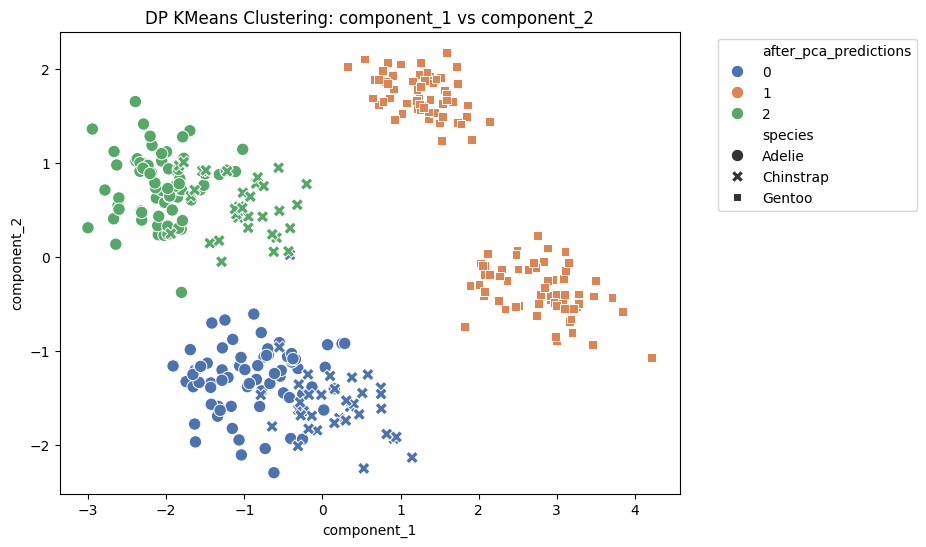

In [85]:
plot_clusters(df, x="component_1", y="component_2", cluster_col="after_pca_predictions")

Again, feel free to try various number of principal components, cluster options, feature selection and axis to plot!

Let's now check what was the total budget spent by the scaler, pca and k-means models.

In [88]:
# TODO: Get epsilon and delta (hint: use the accountant)
# Correction
accountant.total()

(epsilon=2010.0, delta=0.0)

## Step 5: On your Own

DiffPrivLib also provides additional models:
- Gaussian Naive Bayes, 
- Random Forest Classifier,
- Decision Tree Classifier and
- Linear Regressions.

Using these models is very similar to the examples shown here. Apart from the parameters already introduced (`epsilon`, `bounds` and `data_norm`), no additional differentially private settings are required.

Feel free to experiment with these models on your own!